# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data

In [3]:
data = pd.read_csv('../data/train.csv')
data_to_predict = pd.read_csv('../data/test.csv')
data_ccrisk = pd.read_csv('../data/credit_risk_dataset.csv')

data_ccrisk.dropna(inplace=True)
data_ccrisk.drop_duplicates(inplace=True)

X_old = data.drop(['loan_status'], axis=1)
y_old = data['loan_status']

# Merge the dataframes
data_no_id = data.drop(['id'], axis=1)
merged_data = pd.concat([data_no_id, data_ccrisk], ignore_index=True)

def remove_col_prefix(dataframe, prefix):
	dataframe.columns = dataframe.columns.str.replace(prefix, '')
	return dataframe

merged_data = remove_col_prefix(merged_data, 'person_')
merged_data = remove_col_prefix(merged_data, 'loan_')


print(merged_data.isnull().sum())
print(merged_data.duplicated().sum())

age                    0
income                 0
home_ownership         0
emp_length             0
intent                 0
grade                  0
amnt                   0
int_rate               0
percent_income         0
cb_default_on_file     0
cb_cred_hist_length    0
status                 0
dtype: int64
0


# Outliers

In [4]:
from scipy.stats import zscore

numeric_columns = merged_data.select_dtypes(include=[np.number]).columns

def remove_outiers(dataframe, numeric_cols, z_threshold=4):
	dataframe = dataframe[(np.abs(zscore(dataframe[numeric_cols])) < z_threshold).all(axis=1)].copy()
	return dataframe

data_no_outliers = remove_outiers(merged_data, numeric_columns)

In [5]:
merged_data.shape, data_no_outliers.shape

((87146, 12), (85518, 12))

# Feature engineering

## Feature Engineering Pipeline

In [6]:
income_bins = pd.qcut(data_no_outliers['income'], q=5, retbins=True)[1]

def feature_engineering(dataframe, income_bins):
	
	dataframe['emp_length_to_age_ratio'] = dataframe['emp_length']/dataframe['age']
	dataframe['income_to_age_ratio'] = dataframe['income']/dataframe['age']
	dataframe['total_income_to_age_ratio'] = dataframe['emp_length']*dataframe['income']/dataframe['age']
	dataframe['income_category'] = pd.cut(dataframe['income'], bins=income_bins, labels=[1, 2, 3, 4, 5])

	numeric = ['emp_length_to_age_ratio', 'income_to_age_ratio', 'total_income_to_age_ratio']
	ordinal = ['income_category']


	return dataframe, numeric, ordinal

In [7]:
data_no_outliers, new_features_numeric, new_features_ordinal = feature_engineering(data_no_outliers, income_bins)
X = data_no_outliers.drop(['status'], axis=1)
y = data_no_outliers['status']

X

,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,cb_default_on_file,cb_cred_hist_length,emp_length_to_age_ratio,income_to_age_ratio,total_income_to_age_ratio,income_category
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.000000,945.945946,0.000000,1
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.272727,2545.454545,15272.727273,3
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.275862,993.103448,7944.827586,1
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.466667,2333.333333,32666.666667,4
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.090909,2727.272727,5454.545455,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87055,51,76960,MORTGAGE,0.0,PERSONAL,B,15000,9.99,0.19,N,20,0.000000,1509.019608,0.000000,4
87122,51,80000,RENT,3.0,HOMEIMPROVEMENT,F,18000,18.78,0.23,Y,20,0.058824,1568.627451,4705.882353,4
87133,52,30000,RENT,6.0,VENTURE,C,5000,12.73,0.17,N,18,0.115385,576.923077,3461.538462,1
87139,52,65004,RENT,4.0,PERSONAL,D,20000,15.58,0.31,Y,19,0.076923,1250.076923,5000.307692,4


In [8]:
all_data = feature_engineering(merged_data, income_bins)[0]

data_to_predict = remove_col_prefix(data_to_predict, 'person_')
data_to_predict = remove_col_prefix(data_to_predict, 'loan_')
data_to_predict = feature_engineering(data_to_predict, income_bins)[0]

In [9]:
column_names = all_data.columns
column_names

Index(['age', 'income', 'home_ownership', 'emp_length', 'intent', 'grade',
       'amnt', 'int_rate', 'percent_income', 'cb_default_on_file',
       'cb_cred_hist_length', 'status', 'emp_length_to_age_ratio',
       'income_to_age_ratio', 'total_income_to_age_ratio', 'income_category'],
      dtype='object')

In [10]:
X.dtypes

age                             int64
income                          int64
home_ownership                 object
emp_length                    float64
intent                         object
grade                          object
amnt                            int64
int_rate                      float64
percent_income                float64
cb_default_on_file             object
cb_cred_hist_length             int64
emp_length_to_age_ratio       float64
income_to_age_ratio           float64
total_income_to_age_ratio     float64
income_category              category
dtype: object

# Preprocessing

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2, random_state=2024)

In [13]:
categorical_columns = X.select_dtypes(include=['object']).columns

categorical_ordinal = ['grade']
categorical_onehot = categorical_columns.drop(categorical_ordinal)

log_columns = ['age', 'income', 'emp_length', 'amnt']
log_columns = log_columns + new_features_numeric

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop(log_columns)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def log_transform():
	return FunctionTransformer(np.log1p, validate=True)

preprocessor = ColumnTransformer(
	transformers=[
		('ordinal', OrdinalEncoder(), categorical_ordinal),
		('onehot', OneHotEncoder(), categorical_onehot),
		('scaler', StandardScaler(), numerical_columns),
		('log', log_transform(), log_columns)
	], 
	remainder='passthrough',
	force_int_remainder_cols=False
	)

preprocessor.fit(X_train)

X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)
data_prep = preprocessor.transform(all_data)
X_all_prep = preprocessor.transform(X)

# Models

In [15]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [16]:
dtrain = xgb.DMatrix(X_train_prep, label=y_train)
dtest = xgb.DMatrix(X_test_prep, label=y_test)

params = {
	'objective': 'binary:logistic',
	'eval_metric': 'auc',
	'learning_rate'         : 0.03, 
	'n_estimators'          : 5000,
	'max_depth'             : 7, 
	'colsample_bytree'      : 0.75, 
	'colsample_bynode'      : 0.85,
	'colsample_bylevel'     : 0.45,                     
	'reg_alpha'             : 0.001, 
	'reg_lambda'            : 0.25,
	'enable_categorical'    : True,
	'random_state'          : 42,
}

watchlist = [(dtrain, 'train'), (dtest, 'test')]
num_round = 1000
bst = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=30, verbose_eval=10)

[0]	train-auc:0.84085	test-auc:0.83348


c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "enable_categorical", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-auc:0.92654	test-auc:0.92137
[20]	train-auc:0.93062	test-auc:0.92399
[30]	train-auc:0.93217	test-auc:0.92459
[40]	train-auc:0.93402	test-auc:0.92570
[50]	train-auc:0.93647	test-auc:0.92811
[60]	train-auc:0.93817	test-auc:0.92929
[70]	train-auc:0.93969	test-auc:0.93029
[80]	train-auc:0.94137	test-auc:0.93154
[90]	train-auc:0.94286	test-auc:0.93247
[100]	train-auc:0.94428	test-auc:0.93336
[110]	train-auc:0.94554	test-auc:0.93414
[120]	train-auc:0.94661	test-auc:0.93498
[130]	train-auc:0.94842	test-auc:0.93611
[140]	train-auc:0.95039	test-auc:0.93746
[150]	train-auc:0.95155	test-auc:0.93817
[160]	train-auc:0.95239	test-auc:0.93847
[170]	train-auc:0.95359	test-auc:0.93908
[180]	train-auc:0.95427	test-auc:0.93938
[190]	train-auc:0.95529	test-auc:0.94001
[200]	train-auc:0.95614	test-auc:0.94035
[210]	train-auc:0.95751	test-auc:0.94122
[220]	train-auc:0.95851	test-auc:0.94168
[230]	train-auc:0.95960	test-auc:0.94211
[240]	train-auc:0.96048	test-auc:0.94268
[250]	train-auc:0.96147	t

In [17]:
xgb_params = [
	{    
		'objective': 'binary:logistic',
		'learning_rate'         : 0.03, 
		'n_estimators'          : 5000,
		'max_depth'             : 7, 
		'colsample_bytree'      : 0.75, 
		'colsample_bynode'      : 0.85,
		'colsample_bylevel'     : 0.45,                     
		'reg_alpha'             : 0.001, 
		'reg_lambda'            : 0.25,
		'enable_categorical'    : True,
		'random_state'          : 42,
	},
	{
	'objective': 'binary:logistic',
	'eval_metric': 'auc',
	'n_estimators' : 5000,
	'max_depth': 7,
	'eta': 0.08,
	'reg_lambda': 38.5,
	'subsample': 0.88,
	'colsample_bytree': 0.65,
	'enable_categorical': True,
	'min_child_weight': 5,
	},
]

lgb_params = [
	{
		'objective': 'binary', 
		'metric':    'auc',
		'learning_rate'       : 0.0325, 
		'n_estimators'        : 5_000,
		'max_depth'           : 7, 
		'num_leaves'          : 25, 
		'min_data_in_leaf'    : 20,
		'feature_fraction'    : 0.70, 
		'bagging_fraction'    : 0.88, 
		'bagging_freq'        : 6, 
		'lambda_l1'           : 0.001, 
		'lambda_l2'           : 0.1,
	},
	{
		'objective': 'binary', 
		'metric':    'auc',
		'learning_rate'       : 0.035,
		'data_sample_strategy': 'goss', 
		'n_estimators'        : 5_000,
		'max_depth'           : 7, 
		'num_leaves'          : 30, 
		'min_data_in_leaf'    : 30,
		'feature_fraction'    : 0.60, 
		'colsample_bytree'    : 0.65,
		'lambda_l1'           : 0.001, 
		'lambda_l2'           : 1.25,  
	},
	{
		'objective': 'binary',
		'metric': 'auc',
		'max_depth': -1,
		'verbosity': -1,
		'n_estimators': 1500,
		'max_bin': 1024,
		'boosting_type': 'gbdt',
		'colsample_bytree': 0.57,        
		'eta': 0.055,
		'reg_lambda': 10.8,
		'min_child_samples': 70,
	},
]

cat_params = [
	{
		'task_type'           : "CPU",
		'loss_function'       : 'Logloss',
		'eval_metric'         : "AUC",
		'bagging_temperature' : 0.25,
		'colsample_bylevel'   : 0.40,
		'iterations'          : 5_000,
		'learning_rate'       : 0.045,
		'max_depth'           : 7,
		'l2_leaf_reg'         : 0.80,
		'min_data_in_leaf'    : 30,
		'random_strength'     : 0.25,
		'random_state': 42,
	},
	{
		'iterations': 1500,
		'depth': 6,
		'eta': 0.3, 
		'reg_lambda': 41.0, 
		'loss_function': 'Logloss',
		'eval_metric': 'AUC',
		'random_state': 42,
		'min_data_in_leaf': 51,
		'early_stopping_rounds': 150,
		'verbose':200,
	},
	{
		'iterations': 3000,
		'depth': 7,
		'eta': 0.3, 
		'reg_lambda': 40.0, 
		'loss_function': 'Logloss',
		'eval_metric': 'AUC',
		'random_state': 42,
		'min_data_in_leaf': 51,
		'early_stopping_rounds': 300,
		'verbose':200,
	},
	{
		'task_type'           : "CPU",
		'loss_function'       : 'Logloss',
		'eval_metric'         : "AUC",
		'bagging_temperature' : 0.25,
		'colsample_bylevel'   : 0.40,
		'iterations'          : 7_000,
		'learning_rate'       : 0.035,
		'max_depth'           : 8,
		'l2_leaf_reg'         : 0.80,
		'min_data_in_leaf'    : 30,
		'random_strength'     : 0.25,
		'early_stopping_rounds': 200,
		'random_state': 42,
	},
]

In [18]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
	('xgb0', xgb.XGBClassifier(**xgb_params[0])),
	('lgb0', lgb.LGBMClassifier(**lgb_params[0])),
	('lgb1', lgb.LGBMClassifier(**lgb_params[1])),
	('lgb2', lgb.LGBMClassifier(**lgb_params[2])),
	('cat0', CatBoostClassifier(**cat_params[0])),
	('cat1', CatBoostClassifier(**cat_params[1])),
	('cat2', CatBoostClassifier(**cat_params[2])),
	('cat3', CatBoostClassifier(**cat_params[3])),
]

stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

In [ ]:
stacking.fit(X_train_prep, y_train)

In [62]:
from sklearn.metrics import roc_auc_score
y_probas_stacking = stacking.predict_proba(X_test_prep)[:, 1]

print(roc_auc_score(y_test, y_probas_stacking))

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.88, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
0.9592558139270551


In [33]:
stacking.fit(X_all_prep, y)

StackingClassifier(cv=5,
                   estimators=[('lgb0',
                                LGBMClassifier(bagging_fraction=0.88,
                                               bagging_freq=6,
                                               feature_fraction=0.7,
                                               lambda_l1=0.001, lambda_l2=0.1,
                                               learning_rate=0.0325,
                                               max_depth=7, metric='auc',
                                               min_data_in_leaf=20,
                                               n_estimators=5000, num_leaves=25,
                                               objective='binary')),
                               ('lgb2',
                                LGBMClassifier(colsample_bytree=0.57, eta=0.055,
                                               max_bin=1024, metric='auc',
                                               min...
                                               reg_lambda=10.8, verbosity=-1)),
                               ('cat0',
                                <catboost.core.CatBoostClassifier object at 0x000002631BE41A00>),
                               ('cat1',
                                <catboost.core.CatBoostClassifier object at 0x000002631BE3F410>),
                               ('cat2',
                                <catboost.core.CatBoostClassifier object at 0x000002631BE3DD00>),
                               ('cat3',
                                <catboost.core.CatBoostClassifier object at 0x000002631BE3F500>)],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [36]:
data_to_predict = remove_col_prefix(data_to_predict, 'person_')
data_to_predict = remove_col_prefix(data_to_predict, 'loan_')
data_to_predict['emp_length_to_age_ratio'] = data_to_predict['emp_length']/data_to_predict['age']
data_to_predict['income_to_age_ratio'] = data_to_predict['income']/data_to_predict['age']
data_to_predict['total_income_to_age_ratio'] = data_to_predict['emp_length']*data_to_predict['income']/data_to_predict['age']

data_to_predict_prep = preprocessor.transform(data_to_predict)

y_probas_stacking = stacking.predict_proba(data_to_predict_prep)[:, 1]

submission = pd.DataFrame({'id': data_to_predict['id'], 'loan_status': y_probas_stacking})

submission.to_csv('../submissions/stacking_v3.csv', index=False)

In [37]:
import joblib

joblib.dump(stacking, '../models/stacking_v3.pkl')

['../models/stacking_v3.pkl']

In [39]:
submission['loan_bins'] = pd.cut(submission['loan_status'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=[20, 40, 60, 80, 100])

In [ ]:
for loan_proba in submission['loan_status']:
	if loan_proba < 0.2:
		loan_proba = loan_

<Axes: ylabel='Frequency'>

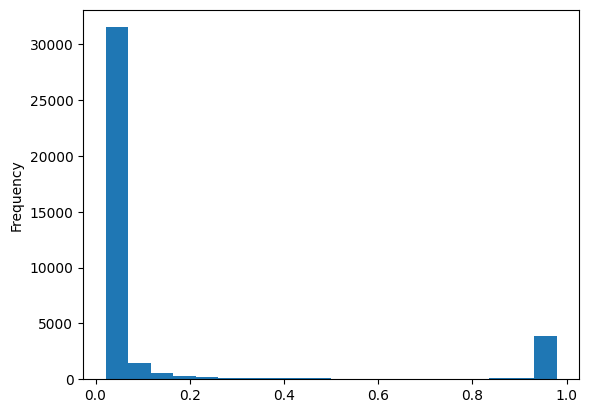

In [85]:
submission['loan_status'].plot(kind='hist', bins=20)

(0.0, 1.0)

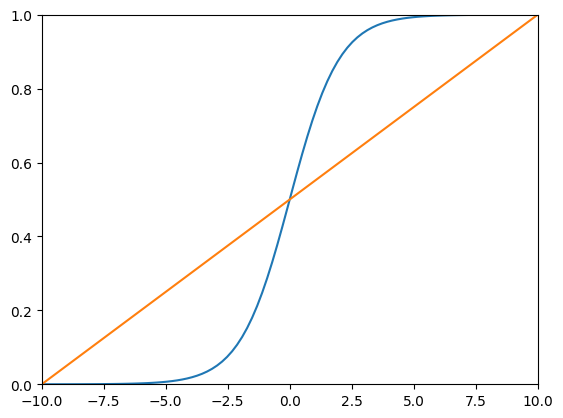

In [98]:
def sigmoid(x):
	return 1/(1 + np.exp(-(x)))

xlim = -10
ylim = 10
plt.plot(np.linspace(xlim, ylim, 100), sigmoid(np.linspace(xlim, ylim, 100)))
plt.plot(np.linspace(xlim, ylim, 100), np.linspace(0, 1, 100))
plt.xlim(-10, 10)
plt.ylim(0, 1)

In [123]:
submission = pd.read_csv('../submissions/stack_model_v2_2.csv')

In [124]:
new_probas = []
for i in range(len(submission['loan_status'])):
	proba = submission['loan_status'][i]
	if proba < 0.2:
		new_probas.append((1-0.4)*proba) 
	elif proba < 0.4 and proba >= 0.2:
		new_probas.append((1-0.25)*proba)
	elif proba < 0.5 and proba >= 0.4:
		new_probas.append((1-0.1)*proba)
	elif proba >= 0.5 and proba < 0.6:
		new_probas.append((1+0.05)*proba)
	elif proba >= 0.6 and proba < 0.8:
		new_probas.append((1+0.1)*proba)
	else:
		new_probas.append(proba)

submission['loan_status_modf'] = new_probas

In [125]:
new_sub = submission.drop(['loan_status'], axis=1)
new_sub.rename(columns={'loan_status_modf': 'loan_status'}, inplace=True)
new_sub.to_csv('../submissions/stack_model_v2_modif.csv', index=False)

In [126]:
new_sub

,id,loan_status
0,58645,0.999033
1,58646,0.011619
2,58647,0.428227
3,58648,0.002626
4,58649,0.040001
...,...,...
39093,97738,0.027058
39094,97739,0.002990
39095,97740,0.003127
39096,97741,0.109028
